# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 24.11.2021

Мягкий дедлайн: 23:59MSK 04.12.2021

Жесткий дедлайн: 23:59MSK 10.12.2021

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
from sklearn.datasets import load_boston

In [3]:
boston = load_boston()

In [4]:
X = boston["data"]
y = boston["target"]

In [5]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [6]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

34.936749868467885

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [7]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    freq = np.zeros(len(X))
    summ = np.zeros(len(X))
    сount = np.zeros(len(X))

    for i in range(num_runs):
        ind = np.random.choice(np.arange(len(X)), size=len(X), replace=True)
        ind_0 = np.setdiff1d(np.arange(len(X)), ind)

        model = regressor.fit(X[ind], y[ind])
        y_pred = model.predict(X[ind_0])

        freq[ind_0] += 1
        summ[ind_0] += y_pred
        сount[ind_0] += np.square(y_pred)

    ind = (freq > 0)
    mean1 = сount[ind] / freq[ind]
    mean = summ[ind] / freq[ind]

    bias = np.mean(np.square(mean - y[ind]))
    variance = np.mean(mean1 - np.square(mean))
    error = np.mean(mean1 + np.square(y[ind]) - 2 * y[ind] * mean)

    return bias, variance, error
    

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

linreg = LinearRegression()
print('---LinearRegression---')
bias, variance, error = compute_biase_variance(linreg, X, y)
print('bias = ', bias, 'variance = ', variance, 'error = ', error)

default_tree = DecisionTreeRegressor()
print('---DecisionTreeRegressor---')
bias, variance, error = compute_biase_variance(default_tree, X, y)
print('bias = ', bias, 'variance = ', variance, 'error = ', error)

default_forest = RandomForestRegressor()
print('---RandomForestRegressor---')
bias, variance, error = compute_biase_variance(default_forest, X, y)
print('bias = ', bias, 'variance = ', variance, 'error = ', error)

---LinearRegression---
bias =  23.856149821734835 variance =  0.9244685222725374 error =  24.780618344007372
---DecisionTreeRegressor---
bias =  10.191851121198312 variance =  12.239422343714804 error =  22.43127346491312
---RandomForestRegressor---
bias =  10.541434931569208 variance =  2.0922246298242038 error =  12.633659561393408


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__  да. LinearRegression - маленький variance/разброс, и большое bias/смезение. DecisionTreeRegressor - variance большще и bias меньше (из-за большой чувствительности к изменениям в выборке)
RandomForestRegressor - bias не изменился (тк отличие от дерева - произошло ансамблирование) и уменьшился variance

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__

In [9]:
from sklearn.ensemble import BaggingRegressor

linreg = BaggingRegressor(LinearRegression())
print('---LinearRegression---')
bias, variance, error = compute_biase_variance(linreg, X, y)
print('bias = ', bias, 'variance = ', variance, 'error = ', error)

default_tree = BaggingRegressor(DecisionTreeRegressor())
print('---DecisionTreeRegressor---')
bias, variance, error = compute_biase_variance(default_tree, X, y)
print('bias = ', bias, 'variance = ', variance, 'error = ', error)

default_forest = BaggingRegressor(RandomForestRegressor())
print('---RandomForestRegressor---')
bias, variance, error = compute_biase_variance(default_forest, X, y, 50)
print('bias = ', bias, 'variance = ', variance, 'error = ', error)

---LinearRegression---
bias =  23.77352863133613 variance =  1.0029090666575997 error =  24.77643769799373
---DecisionTreeRegressor---
bias =  10.390166841860736 variance =  3.345003024130827 error =  13.735169865991562
---RandomForestRegressor---
bias =  11.359852449501645 variance =  1.3096609560414383 error =  12.66951340554308


### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [21]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

In [65]:
def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title="", ax=plt):
    """
    plot graphics described above
    """
    ax.set_ylim(5, 45)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size= num_test_objects / len(y), random_state=42)
    for i in range(num_runs):
        X_sample, y_sample = resample(X_train, y_train)
        model = regressor.fit(X_sample, y_sample)
        y_pred = model.predict(X_test)
        ax.scatter(np.arange(len(X_test)), y_pred, color='red')
    ax.scatter(np.arange(len(X_test)), y_test, color='black')
    ax.set_title(title)

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

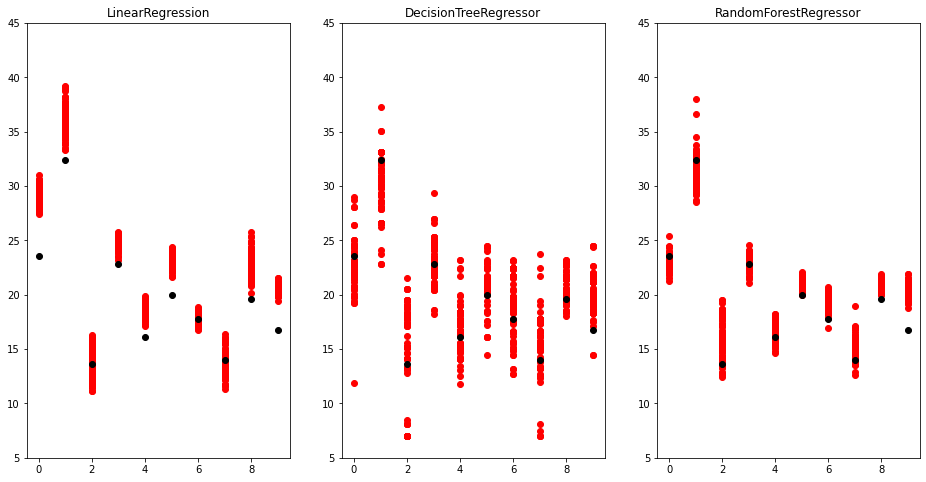

In [68]:
fig, axs = plt.subplots(1, 3, figsize=(16, 8))
plot_predictions(LinearRegression(), X, y, title='LinearRegression', ax=axs[0])
plot_predictions(DecisionTreeRegressor(), X, y, title='DecisionTreeRegressor', ax=axs[1])
plot_predictions(RandomForestRegressor(), X, y, title='RandomForestRegressor', ax=axs[2])

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__ LinearRegression - большой variance и маленький bias тк предсказания близко.
DecisionTreeRegressor большой bias тк предсказания далеко. RandomForestRegressor уменьшился bias каждого дерева но смезение примерно такое же

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [74]:
bias_depth = []
var_depth = []
bias_features = []
var_feature = []
for d in range(1,11):
    default_tree = DecisionTreeRegressor(max_depth=d)
    bis, var, er = compute_biase_variance(default_tree, X, y)
    bias_depth.append(bis)
    var_depth.append(var)
for f in range(1, X.shape[1] + 1):
    model = DecisionTreeRegressor(max_features=f)
    bis, var, er = compute_biase_variance(model, X, y)
    bias_features.append(bis)
    var_feature.append(var)

Text(0.5, 0, 'max_features')

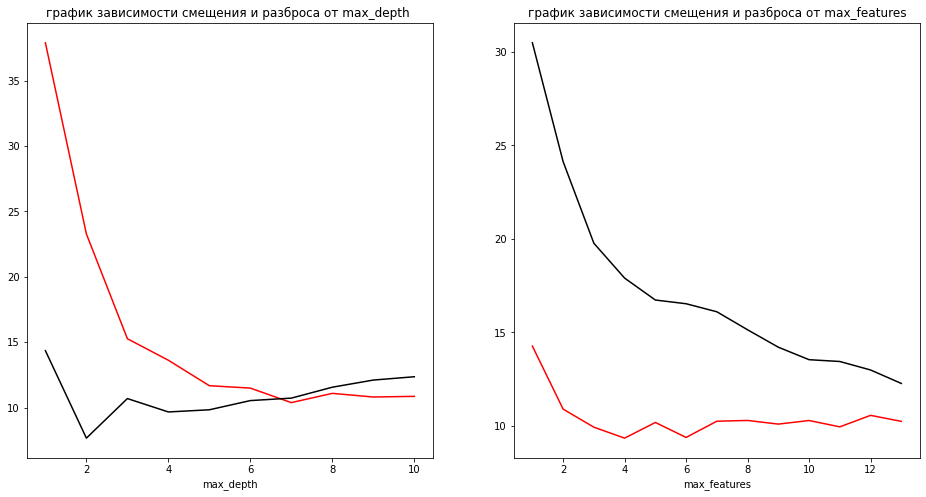

In [95]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(range(1,11), bias_depth, label='Bias', color='red')
plt.plot(range(1,11), var_depth, label='Variance', color='black')
plt.title('график зависимости смещения и разброса от max_depth ')
plt.xlabel('max_depth')
plt.subplot(1,2,2)
plt.plot(range(1, X.shape[1] + 1), bias_features, label='Bias', color='red')
plt.plot(range(1, X.shape[1] + 1), var_feature, label='Variance', color='black')
plt.title('график зависимости смещения и разброса от max_features')
plt.xlabel('max_features')

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [85]:
from sklearn.ensemble import GradientBoostingRegressor

In [87]:
arr = 2**np.arange(1, 10)

In [88]:
arr

array([  2,   4,   8,  16,  32,  64, 128, 256, 512])

In [89]:
bias_defforest = []
var_defforest = []
bias_boosting = []
var_boosting = []
for i in arr:
    model = RandomForestRegressor(n_estimators=i)
    bis, var, er = compute_biase_variance(model, X, y)
    bias_defforest.append(bis)
    var_defforest.append(var)
    model = GradientBoostingRegressor(n_estimators=i)
    bis, var, er = compute_biase_variance(model, X, y)
    bias_boosting.append(bis)
    var_boosting.append(var)

Text(0.5, 0, 'n_estomators')

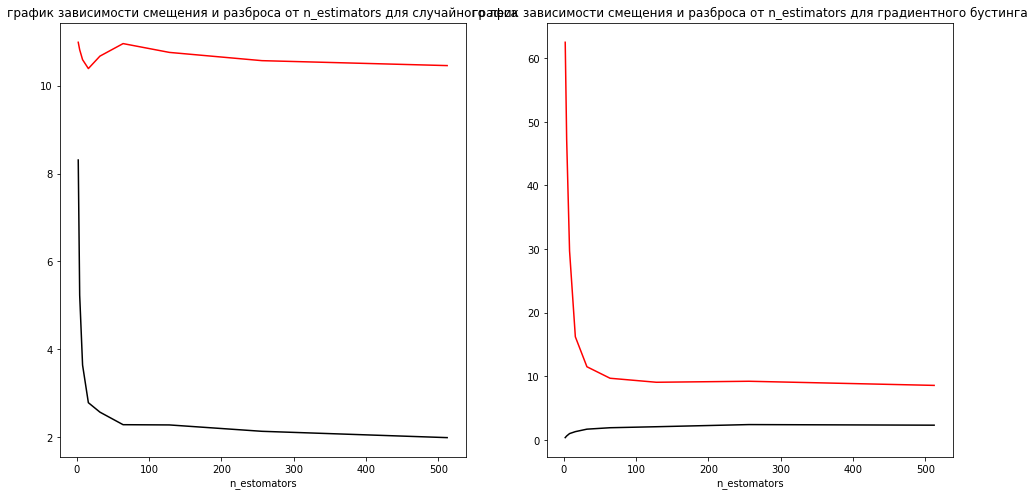

In [94]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(2 ** np.arange(1,10), bias_defforest, label='bias', color='red')
plt.plot(2 ** np.arange(1,10), var_defforest, label='variance', color='black')
plt.title('график зависимости смещения и разброса от n_estimators для случайного леса')
plt.xlabel('n_estomators')
plt.subplot(1,2,2)
plt.plot(2 ** np.arange(1,10), bias_boosting, label='bias',color='red')
plt.plot(2 ** np.arange(1,10), var_boosting, label='variance',color='black')
plt.title('график зависимости смещения и разброса от n_estimators для градиентного бустинга')
plt.xlabel('n_estomators')

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

1 картинка: 
до max_depth = 2 у нас хорошо (variance падает) а потом он начинает расти (происходит переобучение) а bias падает (по картинке видно что в нашем случае лучше брать max_depth небольшим)

2 картинка: С увеличением max_feature уменьшается variance (изпользуем больше информации) а bias немного начинает расти (по картинке видно что большое значение параметра нам помогает)

3 картинка: С увеличением n_estomators уменьшается variance (берем средний ответ по большему числу деревьев) но при очень большом значении параметра нет существенных изменений (по картинке видно что СЛИШКОМ большое значение параметра нам помогает)

4 картинка: С увеличением n_estomators (тк бустинг минимизирует ошибку) поэтому bias уменьшается до определенного значения а потом не меняется особо а вот variance незначительнот растет (по картинке видно что СЛИШКОМ большое значение параметра нам помогает)


Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.